# 12__haplotypes
# determining whether SNPs act additively vs epistatically

in this notebook, i determine whether SNPs interact together additively or epistatically. whenever multiple SNPs show up together in a tile (i.e., a "haplotype"), i determine the "expected" (additive) effect size of the haplotype by adding all of the effect sizes of the individual SNPs together. i then bootstrap this expected effect size 1000 times and call those falling outside of the 90% confidence interval as being epistatic.

------

figures in this notebook:
- **Fig 4D**: swarm plots of 2 representative haplotypes -- one additive and one not

In [1]:
import warnings
warnings.filterwarnings('ignore')

import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import time

from decimal import Decimal
from os import walk
from scipy import stats
from scipy.stats import spearmanr
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *
from snp_utils import *
from del_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE
np.random.seed(SEED)

## variables

In [3]:
hepg2_snp_data_f = "../../data/07__snps/HepG2__POOL1_active_snp_results.txt"
k562_snp_data_f = "../../data/07__snps/K562__POOL1_active_snp_results.txt"

In [4]:
hepg2_activity_data_f = "../../data/02__activs/POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
k562_activity_data_f = "../../data/02__activs/POOL1__pMPRA1__K562__activities_per_barcode.txt"

In [5]:
index_f = "../../data/00__index/tss_oligo_pool.index.txt"

## 1. import data

In [6]:
hepg2_snp_data = pd.read_table(hepg2_snp_data_f, sep="\t")
k562_snp_data = pd.read_table(k562_snp_data_f, sep="\t")
hepg2_snp_data.head()

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_7_sig,rna_8_sig,rna_9_sig,rna_10_sig,rna_11_sig,rna_12_sig,rna_13_sig,rna_14_sig,combined_sig,downsamp_sig
0,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:1...,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,rs4970820,2.286466,2.533175,2.211489,2.237811,2.524265,2.422148,2.438239,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig
1,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,rs60844753,-0.679607,-0.052697,-0.361549,-1.073497,0.170735,-1.000654,-0.302448,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs
2,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,rs60844753,-1.017332,-0.704733,-1.000190,-1.037288,-0.954753,-0.818438,-1.384316,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,not sig
3,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,rs115274951,2.660158,3.402034,2.624243,2.543345,2.855234,2.842446,2.861128,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig
4,WILDTYPE_SNP_INDIV__Antisense.noflip.NA__chr1:...,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,rs1555794,-0.481365,-0.627272,-0.793396,-0.527694,-0.820784,-0.377691,-0.418729,...,not sig,not sig,not sig,NA__too_many_rep_NAs,not sig,not sig,not sig,not sig,not sig,not sig


In [7]:
hepg2_activ = pd.read_table(hepg2_activity_data_f, sep="\t")
k562_activ = pd.read_table(k562_activity_data_f, sep="\t")
hepg2_activ.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [8]:
hepg2_reps = [x for x in hepg2_activ.columns if x != "barcode"]
k562_reps = [x for x in k562_activ.columns if x != "barcode"]

hepg2_activ["rep_mean"] = np.nanmean(hepg2_activ[hepg2_reps], axis=1)
k562_activ["rep_mean"] = np.nanmean(k562_activ[k562_reps], axis=1)

hepg2_activ.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14,rep_mean
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733,0.027407
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116,-1.791050
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801,0.569231
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410,0.988478
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594,-0.002360


In [9]:
index = pd.read_table(index_f, sep="\t")
index.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,tile_number,local_start,local_end,RE_count_1,RE_count_2,RE_count_3,SNP,barcode,element,unique_id
0,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.1,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,CTCGTAACGGG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
1,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.2,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,ATACGCGATTG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
2,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.3,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,GAAACGTAAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
3,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.4,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,GTACTAAGAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....
4,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.5,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,1.0,0.0,114.0,1,1,0,none,ACTTTCCGACG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....


In [10]:
index_elem = index[["oligo_type", "dupe_info", "seq_name", "tile_name", "chr", "locus_start", "locus_end",
                    "strand", "element", "unique_id", "SNP"]].drop_duplicates()
index_elem.head()

,oligo_type,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,element,unique_id,SNP
0,WILDTYPE,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,none
15,WILDTYPE,none,"Lincrna.flip.sense__chr1:100731637..100731751,-","Lincrna.flip.sense__chr1:100731637..100731751,...",chr1,100731637.0,100731751.0,-,CCCGGGTTCGCCCAGTTCCGCAGTCAGTGCGCATGCGCGTAGCTCG...,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,none
30,WILDTYPE_BUT_HAS_SNP,none,"Lincrna.flip.sense__chr1:109642741..109642855,+","Lincrna.flip.sense__chr1:109642741..109642855,...",chr1,109642741.0,109642855.0,+,TTTCTCCCAGAATCCTCCAAGGCGCGGGAGGGGGCGGAGAGCTTAA...,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,none
62,WILDTYPE_SNP_INDIV,none,"Lincrna.flip.sense__chr1:109642741..109642855,+","Lincrna.flip.sense__chr1:109642741..109642855,...",chr1,109642741.0,109642855.0,+,TTTCTCCCAGAATCCTCCAAGGCGCGGGAAGGGGCGGAGAGCTTAA...,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:1...,rs4970820
94,WILDTYPE,none,"Antisense.noflip.NA__chr1:110881743..110881857,-",Antisense.noflip.NA__chr1:110881743..110881857...,chr1,110881743.0,110881857.0,-,CCAGACTGTAGCTCCGCCCCTCGCACTCTGCGGTCACGTGACCCAA...,WILDTYPE__Antisense.noflip.NA__chr1:110881743....,none


In [11]:
hepg2_data = index.merge(hepg2_activ, on="barcode", how="outer")
k562_data = index.merge(k562_activ, on="barcode", how="outer")
k562_data.head()

,full_oligo,oligo_type,oligo_id,dupe_info,seq_name,tile_name,chr,locus_start,locus_end,strand,...,RE_count_3,SNP,barcode,element,unique_id,rna_1,rna_2,rna_3,rna_4,rep_mean
0,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.1,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0,none,CTCGTAACGGG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,0.805789,2.108164,2.446692,1.237843,1.649622
1,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.2,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0,none,ATACGCGATTG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,1.148301,2.023382,2.483470,0.930838,1.646498
2,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.3,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0,none,GAAACGTAAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,0.230184,1.440360,2.450393,0.141442,1.065595
3,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.4,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0,none,GTACTAAGAGT,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,0.725577,2.440306,2.505078,1.702623,1.843396
4,ACTGGCCGCTTCACTGGTGCAGCCCAGGCGTTTCCGGGTTCCCGCG...,WILDTYPE,1.1.0.0.5,none,"Antisense.noflip.NA__chr1:100435456..100435570,-",Antisense.noflip.NA__chr1:100435456..100435570...,chr1,100435456.0,100435570.0,-,...,0,none,ACTTTCCGACG,GTGCAGCCCAGGCGTTTCCGGGTTCCCGCGGTCCCGTCCCCCAAAT...,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,-1.008794,-0.821401,2.603555,2.809064,0.895606


## 2. find haplotypes

In [12]:
hepg2_haplo_ids = hepg2_snp_data[hepg2_snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO")]["unique_id"]
hepg2_haplo_wts = hepg2_snp_data[hepg2_snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO")]["wt_id"]

k562_haplo_ids = k562_snp_data[k562_snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO")]["unique_id"]
k562_haplo_wts = k562_snp_data[k562_snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO")]["wt_id"]

In [13]:
hepg2_reps.extend(["combined"])
k562_reps.extend(["combined"])
k562_reps

['rna_1', 'rna_2', 'rna_3', 'rna_4', 'combined']

In [14]:
hepg2_all_haplo_sig_ids = []
hepg2_all_haplo_sig_wts = []

k562_all_haplo_sig_ids = []
k562_all_haplo_sig_wts = []

for snp_data, reps, all_haplo_sig_ids, all_haplo_sig_wts in zip([hepg2_snp_data, k562_snp_data], 
                                                                [hepg2_reps, k562_reps], 
                                                                [hepg2_all_haplo_sig_ids, k562_all_haplo_sig_ids],
                                                                [hepg2_all_haplo_sig_wts, k562_all_haplo_sig_wts]):
    for rep in reps:
        sig_col = "%s_sig" % rep
        haplo_sig_ids = snp_data[(snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO")) & 
                                 (snp_data[sig_col]=="sig")]["unique_id"]
        haplo_wt_ids = snp_data[snp_data["unique_id"].str.contains("WILDTYPE_SNP_PLUS_HAPLO") & 
                                (snp_data[sig_col]=="sig")]["wt_id"]
        all_haplo_sig_ids.append(haplo_sig_ids)
        all_haplo_sig_wts.append(haplo_wt_ids)

In [15]:
len(k562_all_haplo_sig_ids[-1])

36

In [16]:
len(k562_all_haplo_sig_wts[-1])

36

## 3. bootstrap the effect size of haplotypes

In [17]:
def n_char(row):
    return len(row["SNP"])
hepg2_snp_data["SNP_chars"] = hepg2_snp_data.apply(n_char, axis=1)
k562_snp_data["SNP_chars"] = k562_snp_data.apply(n_char, axis=1)
hepg2_snp_data.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_8_sig,rna_9_sig,rna_10_sig,rna_11_sig,rna_12_sig,rna_13_sig,rna_14_sig,combined_sig,downsamp_sig,SNP_chars
1147,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr22:5096...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr22:50...,rs131804,-0.811586,-1.003207,0.928498,-0.299443,-0.009927,-0.179146,0.559761,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,8
1182,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr4:10891...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr4:108...,rs760202,3.977966,1.287302,1.981815,0.422670,3.157316,2.165970,2.161096,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,8
357,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr4:17...,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr4:...,rs59451701,-0.505805,-0.829894,-1.150191,-0.955159,-0.890435,-0.829455,-0.785753,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,sig,not sig,10
1711,WILDTYPE_SNP_INDIV__Enhancer.flip.sense__chr22...,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,rs7284768,-0.739728,-0.799735,-0.629320,-0.811111,-0.805968,-0.797009,-0.816180,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,9
1573,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr10:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs7090417,0.705846,0.966618,0.693153,0.794295,0.750522,0.785220,0.660207,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,9


In [18]:
def fixed_names(row):
    if "," in row["SNP"]:
        return "haplotype"
    else:
        return row["SNP"]
hepg2_snp_data["SNP_fixed"] = hepg2_snp_data.apply(fixed_names, axis=1)
k562_snp_data["SNP_fixed"] = k562_snp_data.apply(fixed_names, axis=1)
hepg2_snp_data.sample(5)

,unique_id,wt_id,SNP,rna_3_wt_med,rna_4_wt_med,rna_5_wt_med,rna_6_wt_med,rna_7_wt_med,rna_8_wt_med,rna_9_wt_med,...,rna_9_sig,rna_10_sig,rna_11_sig,rna_12_sig,rna_13_sig,rna_14_sig,combined_sig,downsamp_sig,SNP_chars,SNP_fixed
1446,WILDTYPE_SNP_PLUS_HAPLO__Enhancer.noflip.NA__c...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr7...,"rs2941540,rs28428869,rs116659474,rs2964954,rs2...",-1.258183,-0.782907,-0.776913,-1.016069,-0.834209,-0.981500,-0.775922,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,sig,sig,not sig,52,haplotype
588,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr13:1021...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr13:10...,rs16958936,-1.789720,-1.189230,-1.469107,-1.913760,-1.676156,-1.695730,-1.819948,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,10,rs16958936
1585,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr19:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs7251881,-0.913967,-0.812273,-1.049357,-1.160064,-0.779008,-0.930756,-1.333450,...,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,not sig,not sig,not sig,not sig,9,rs7251881
222,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,rs113640298,3.435458,3.954702,3.442599,3.042606,3.525791,3.565668,3.340304,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,11,rs113640298
1732,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr6:3...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr6...,rs28383183,-0.262731,0.178750,0.003608,0.003926,0.014120,0.111484,0.125156,...,not sig,not sig,not sig,not sig,not sig,not sig,not sig,not sig,10,rs28383183


In [19]:
hepg2_wt_seqs = index[index["unique_id"].isin(hepg2_snp_data["wt_id"])]
hepg2_wt_seqs = hepg2_wt_seqs[["unique_id", "element"]].drop_duplicates()
hepg2_wt_seqs_dict = {k:v for k,v in zip(list(hepg2_wt_seqs["unique_id"]), list(hepg2_wt_seqs["element"]))}
len(hepg2_wt_seqs_dict)

1000

In [20]:
k562_wt_seqs = index[index["unique_id"].isin(k562_snp_data["wt_id"])]
k562_wt_seqs = k562_wt_seqs[["unique_id", "element"]].drop_duplicates()
k562_wt_seqs_dict = {k:v for k,v in zip(list(k562_wt_seqs["unique_id"]), list(k562_wt_seqs["element"]))}
len(k562_wt_seqs_dict)

1000

In [21]:
hepg2_snp_seqs = index[index["unique_id"].isin(hepg2_snp_data["unique_id"])]
hepg2_snp_seqs = hepg2_snp_seqs[["unique_id", "element"]].drop_duplicates()
hepg2_snp_seqs_dict = {k:v for k,v in zip(list(hepg2_snp_seqs["unique_id"]), list(hepg2_snp_seqs["element"]))}
len(hepg2_snp_seqs_dict)

1783

In [22]:
k562_snp_seqs = index[index["unique_id"].isin(k562_snp_data["unique_id"])]
k562_snp_seqs = k562_snp_seqs[["unique_id", "element"]].drop_duplicates()
k562_snp_seqs_dict = {k:v for k,v in zip(list(k562_snp_seqs["unique_id"]), list(k562_snp_seqs["element"]))}
len(k562_snp_seqs_dict)

1783

In [23]:
def get_snp_pos(row, wt_seqs_dict, snp_seqs_dict, max_snps_per_tile):
    wt_id = row["wt_id"]
    snp_id = row["unique_id"]
    wt_seq = wt_seqs_dict[wt_id]
    snp_seq = snp_seqs_dict[snp_id]
    try:
        pos = [i for i in range(len(wt_seq)) if wt_seq[i] != snp_seq[i]][0]
    except:
        pos = [i for i in range(len(snp_seq)) if wt_seq[i] != snp_seq[i]][0]
    pos = pos-10
    return pos

In [24]:
hepg2_snp_data["snp_pos"] = hepg2_snp_data.apply(get_snp_pos, wt_seqs_dict=hepg2_wt_seqs_dict, 
                                                 snp_seqs_dict=hepg2_snp_seqs_dict, max_snps_per_tile=11, axis=1)
k562_snp_data["snp_pos"] = k562_snp_data.apply(get_snp_pos, wt_seqs_dict=k562_wt_seqs_dict, 
                                               snp_seqs_dict=k562_snp_seqs_dict, max_snps_per_tile=11, axis=1)
k562_snp_data.sample(5)

,unique_id,wt_id,SNP,rna_1_wt_med,rna_2_wt_med,rna_3_wt_med,rna_4_wt_med,combined_wt_med,rna_1_snp_med,rna_2_snp_med,...,rna_4_padj,combined_padj,rna_1_sig,rna_2_sig,rna_3_sig,rna_4_sig,combined_sig,SNP_chars,SNP_fixed,snp_pos
1368,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr10:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs12571328,-2.014454,-0.810606,0.305530,-0.622177,-0.785427,-2.575027,-1.143688,...,1,1,NA__too_many_rep_NAs,not sig,not sig,not sig,not sig,10,rs12571328,68
709,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr9:94124...,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr9:941...,rs184467783,NaN,-1.065996,2.069869,-1.865935,-0.287354,NaN,2.338151,...,NA__not_enough_barcodes,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,11,rs184467783,1
1674,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr10:...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs9415066,-2.330748,-1.074790,-2.135307,-3.573844,-2.278672,-3.127894,-3.537469,...,NA__not_enough_barcodes,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,9,rs9415066,16
1454,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr1:2...,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,rs6695176,-2.538985,-1.957457,-1.923756,-2.644501,-2.266175,-3.217611,-3.077865,...,NA__no_active_tile,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,NA__too_many_rep_NAs,9,rs6695176,78
189,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr1...,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,rs116006788,2.325163,3.471705,3.906655,3.108829,3.203088,2.227631,3.431585,...,1,1,not sig,not sig,not sig,not sig,not sig,11,rs116006788,20


In [25]:
def get_num(row, num_dict):
    return num_dict[row["SNP_fixed"]]

In [26]:
def plot_and_fit_bootstrap(df_w_data, col, name, n_sim, ci_percent, plotname, save):
    median_width = 0.3
    # df no haplo
    df_no_hap = df_w_data[~df_w_data["SNP_fixed"].isin(["haplotype"])]

    # find med. per SNP
    med_per_snp = df_no_hap.groupby(["SNP_fixed"])[col].agg("median").reset_index()
    max_snp = med_per_snp[col].max()
    min_snp = med_per_snp[col].min()
    wt_val = med_per_snp[med_per_snp["SNP_fixed"] == "wildtype"][col].iloc[0]

    med_per_snp = med_per_snp[med_per_snp["SNP_fixed"] != "wildtype"]
    order = ["wildtype"]
    if max_snp > wt_val:
        # order ascending w/ wt first
        SNP_order = med_per_snp.sort_values(by=col, ascending=True)["SNP_fixed"]
    else:
        # order descending w/ wt first
        SNP_order = med_per_snp.sort_values(by=col, ascending=False)["SNP_fixed"]
    order.extend(SNP_order)
    order.extend(["haplotype"])

    # fix snp names
    num_dict = dict(zip(order, list(range(0, len(order)))))
    df_no_hap["SNP_num"] = df_no_hap.apply(get_num, axis=1, num_dict=num_dict)
    df_w_data["SNP_num"] = df_w_data.apply(get_num, axis=1, num_dict=num_dict)
    num_order = list(range(0,len(order)))
    
    # find actual additive effect from data
    wt_median = np.nanmedian(df_w_data[df_w_data["SNP_num"] == 0][col])
    actual_effect = 0
    for s in range(1, len(num_order)-1):
        snp_median = np.nanmedian(df_w_data[df_w_data["SNP_num"] == s][col])
        actual_effect += snp_median - wt_median
    #print("wt med: %s | real effect: %s" % (wt_median, actual_effect))
    
    # bootstrap this additive effect
    effects = np.zeros((1, n_sim))
    for n in range(n_sim):
        effect = 0
        
        # find wt bootstrap med
        vals = np.array(df_w_data[df_w_data["SNP_num"] == 0][col])
        n_vals = len(vals)
        vals_boot = np.random.choice(vals, size=n_vals, replace=True)
        wt_boot_median = np.nanmedian(vals_boot)
        
        # find snp effect on wt
        for s in range(1, len(num_order)-1):
            vals = np.array(df_w_data[df_w_data["SNP_num"] == s][col])
            n_vals = len(vals)
            vals_boot = np.random.choice(vals, size=n_vals, replace=True)
            vals_boot_median = np.nanmedian(vals_boot)
            effect += vals_boot_median - wt_boot_median
        effects[0, n] = effect
    
    diffs = effects - actual_effect
    diffs_sort = np.sort(diffs)   
    
    # find bounds of confidence interval
    lower_percentile = (1 - ci_percent)/2.
    upper_percentile = 1 - lower_percentile
    #print("lower perc: %s | upper perc: %s" % (lower_percentile, upper_percentile))
    
    lower_idx = int(round(lower_percentile * n_sim) - 1)
    upper_idx = int(round(upper_percentile * n_sim) - 1)
    #print("lower idx: %s | upper idx: %s" % (lower_idx, upper_idx))
    
    lower_bound = actual_effect - diffs_sort[0, upper_idx]
    upper_bound = actual_effect - diffs_sort[0, lower_idx]
    #print("lower bound: %s | upper bound: %s" % (lower_bound, upper_bound))
    
    # translate that into an actual activity value
    additive_hap = actual_effect + wt_median
    additive_hap_low = lower_bound + wt_median
    additive_hap_high = upper_bound + wt_median
    #print("haplotype effect: [%s, %s] median: %s" % (additive_hap_low, additive_hap_high, additive_hap))
    
    # record difference b/w actual effect & additive effect
    additiveness = np.abs(actual_effect - additive_hap)
    
    # see if hap median falls w/in bounds
    hap_median = np.nanmedian(df_w_data[df_w_data["SNP_fixed"] == "haplotype"][col])
    if hap_median > additive_hap_low and hap_median < additive_hap_high:
        additive = "additive"
    elif hap_median < additive_hap_low:
        additive = "sub-additive"
    elif hap_median > additive_hap_high:
        additive = "super-additive"

    fig = plt.figure(figsize=(len(df_w_data.SNP.unique())*0.4+1,1))

    # swarm plot - no hap
    ax = sns.swarmplot(x="SNP_num", y=col, data=df_w_data[df_w_data["SNP_fixed"]=="wildtype"], 
                       color="lightgrey", order=num_order, zorder=1)
    sns.swarmplot(x="SNP_num", y=col, data=df_no_hap[df_no_hap["SNP_fixed"]!="wildtype"], 
                  color="darkgrey", 
                  order=num_order, zorder=1, ax=ax)
    ax.set_xlim((-0.5, len(order)))
    
    # swarm plot - hap
    sns.swarmplot(x="SNP_num", y=col, data=df_w_data[df_w_data["SNP_fixed"]=="haplotype"], 
                  color=sns.color_palette()[2], order=num_order, ax=ax, zorder=5)
    
    # median bars
    for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
        snp = int(text.get_text())

        # calculate the median value for all replicates of either X or Y
        median_val = df_w_data[df_w_data["SNP_num"]==snp][col].median()

        # plot horizontal lines across the column, centered on the tick
        ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],
                lw=1, color='k', zorder=10)
    
    # fill between - confidence band
    hap_num = num_order[-1]
    x = [hap_num-0.5, hap_num+0.5]
    y1 = [additive_hap_low, additive_hap_low]
    y2 = [additive_hap_high, additive_hap_high]
    plt.fill_between(x, y1, y2, color=sns.color_palette()[2], alpha=0.2, zorder=1)
    
    # line delineating wt and hap
    plt.axvline(x=0.5, linestyle="dashed", color="black", linewidth=1)
    plt.axvline(x=hap_num-0.5, linestyle="dashed", color="black", linewidth=1)
    
    # line delineating bottom and top CIs
    plt.plot(x, y1, color="black", linewidth=1, zorder=1)
    plt.plot(x, y2, color="black", linewidth=1, zorder=1)
    
    # other plot aesthetics
    plt.xlabel("")
    if col != "rep_mean":
        plt.ylabel("MPRA activity")
    else:
        plt.ylabel("MPRA activity")
    title = "%s\n%s\n[additive = %s]" % (name, col, additive)
    plt.title(title)
    labels = ["reference"]
    labels.extend([x for x in order if x != "wildtype"])
    #print(labels)
    
    # find min and max for plot
    plot_min = np.min([df_w_data[col].min(), additive_hap_low])
    plot_max = np.max([df_w_data[col].max(), additive_hap_high])
    
    plt.ylim((plot_min-0.5, plot_max+0.5))
    ax.set_xticklabels(labels, rotation=30)
    if save:
        plt.show()
        fig.savefig("%s.pdf" % (plotname), dpi="figure", bbox_inches="tight")
    else:
        plt.close()
    return additive, additiveness

In [27]:
len(all_haplo_sig_wts)

5

HepG2


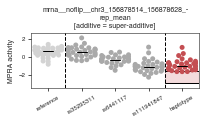

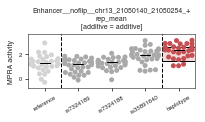

K562


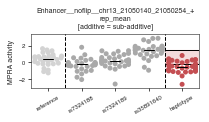

In [28]:
hepg2_all_additive_results = {}
k562_all_additive_results = {}

hepg2_combined_haplo_sig_ids = hepg2_all_haplo_sig_ids[-1]
hepg2_combined_haplo_sig_wts = hepg2_all_haplo_sig_wts[-1]

k562_combined_haplo_sig_ids = k562_all_haplo_sig_ids[-1]
k562_combined_haplo_sig_wts = k562_all_haplo_sig_wts[-1]

zipped = zip([hepg2_combined_haplo_sig_ids, k562_combined_haplo_sig_ids], 
             [hepg2_combined_haplo_sig_wts, k562_combined_haplo_sig_wts],
             [hepg2_all_additive_results, k562_all_additive_results],
             [hepg2_data, k562_data], ["HepG2", "K562"])

for haplo_sig_ids, haplo_sig_wts, all_additive_results, data, cell in zipped:
    print(cell)
    col = "rep_mean"
    for i, wt_id in enumerate(haplo_sig_wts):
        seq_type = wt_id.split("__")[1].split(".")[0]
        flip_type = wt_id.split("__")[1].split(".")[1]
        loc = wt_id.split("__")[2].split(",")[0]
        chrom = loc.split(":")[0]
        start = loc.split(":")[1].split("..")[0]
        end = loc.split(":")[1].split("..")[1]
        strand = wt_id.split("__")[2].split(",")[1]
        name = "%s__%s__%s_%s_%s_%s" % (seq_type, flip_type, chrom, start, end, strand)

        # df finagling
        df = snp_data[snp_data["wt_id"] == wt_id][["unique_id", "SNP", "SNP_chars", "SNP_fixed", "snp_pos"]]
        snps = df[["SNP", "SNP_fixed", "SNP_chars"]].sort_values(by="SNP_chars")["SNP"]
        df_w_data = df.merge(data[["unique_id", "barcode", col]], on="unique_id")
        df_w_data = df_w_data.append(data[data["unique_id"] == wt_id][["unique_id", "barcode", col]])
        df_w_data["SNP_fixed"] = df_w_data["SNP_fixed"].fillna("wildtype")

        if len(df_w_data.SNP.unique()) <= 3:
            # more than 1 SNP does not exist
            continue

        # find min dist between snps
        pos = list(set(list(df["snp_pos"])))
        combos = list(itertools.combinations(pos, 2))
        dists = [np.abs(x[0]-x[1]) for x in combos]
        min_dist = np.min(dists)

        if name in ["Enhancer__noflip__chr13_21050140_21050254_+", "mrna__noflip__chr3_156878514_156878628_-"]:
            save = True
            plotname = "Fig_4D_%s_%s" % (name.split("__")[0], cell)
        else:
            save = False
            plotname = None
        additive, additiveness = plot_and_fit_bootstrap(df_w_data, col, name, 1000, 0.9, plotname, save)
        all_additive_results[name] = (additive, additiveness, min_dist)

## 3. find % of additive and non additive haplotypes

In [29]:
hepg2_results = pd.DataFrame.from_dict(data=hepg2_all_additive_results, orient="index").reset_index()
hepg2_results.columns = ["name", "status", "additiveness", "min_dist"]
hepg2_results.head()

,name,status,additiveness,min_dist
0,Antisense__noflip__chr11_77850775_77850889_+,additive,0.705559,6
1,Lincrna__flip__chr13_99852893_99853007_-,additive,1.589496,8
2,Lincrna__flip__chr16_2014868_2014982_+,additive,2.179078,19
3,Antisense__flip__chr17_20771760_20771874_+,additive,0.940757,6
4,Lincrna__noflip__chr19_37742733_37742847_+,additive,3.515326,2


In [30]:
k562_results = pd.DataFrame.from_dict(data=k562_all_additive_results, orient="index").reset_index()
k562_results.columns = ["name", "status", "additiveness", "min_dist"]
k562_results.head()

,name,status,additiveness,min_dist
0,Lincrna__flip__chr13_99852893_99853007_-,additive,0.650087,8
1,Lincrna__flip__chr16_2014868_2014982_+,sub-additive,2.638288,19
2,Antisense__flip__chr19_54960184_54960298_-,additive,1.495073,46
3,Lincrna__noflip__chr20_48909177_48909291_+,additive,1.597313,76
4,Antisense__noflip__chr3_40494765_40494879_-,additive,1.365904,55


In [31]:
hepg2_results.status.value_counts()

additive          67
super-additive     9
sub-additive       4
Name: status, dtype: int64

In [32]:
k562_results.status.value_counts()

additive          25
sub-additive       5
super-additive     2
Name: status, dtype: int64